TASC6/KASC13 Workshop
--

---

# Stellar Models for Asteroseismology


by [Earl Patrick Bellinger](https://earlbellinger.com)$^{1,2}$

$^1$_Max Planck Institute for Astrophysics, Garching, Germany_ \
$^2$_Stellar Astrophysics Centre, Aarhus, Denmark_

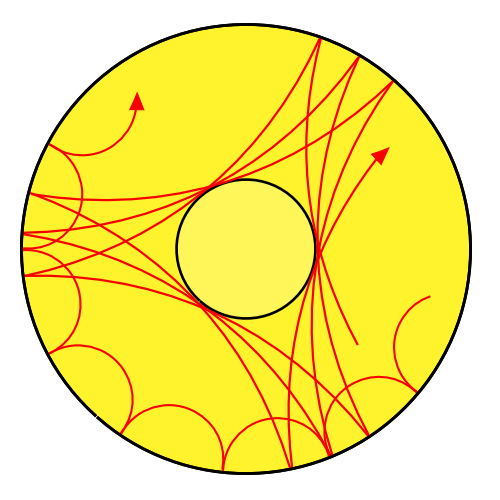

## Installation

This tutorial is about [MESA](https://docs.mesastar.org/) and [GYRE](https://gyre.readthedocs.io). Let's install them!

In the `src/` directory you will find `install_mesa.sh`. Run it line-by-line so that you may catch any errors that crop up. You will likely need to install some extra packages along the way, and then start over from the beginning. 


Once the installation script is finished, you should see: 


```
************************************************
************************************************
************************************************

MESA installation was successful

************************************************
************************************************
************************************************
```

Hooray! You are ready to get started. 

## Your first MESA run 

Let's copy a fresh work directory over: 

```language:bash
cp -R $MESA_DIR/star/work .
cp -R $MESA_DIR/star/defaults/*.list work
cd work
./mk
./rn
```

That should have worked. If so, we're ready to compute some models for asteroseismology. 

Let's change the mass, initial chemical composition, and mixing length parameter so that we roughly get a solar-like model. You can copy over the values from my inlist given in the `src/` directory. I have also instructed MESA to output [FGONG](https://phys.au.dk/~jcd/ASTEC_results/file-format.pdf) whenever a profile file is generated. 

Let's also uncomment `delta_nu` and `nu_max` from `history_columns.list`, and `brunt_N2` and `lamb_S` from `profile_columns.list`. 

Now when we run this we should get some output in the LOGS directory. Let's analyze that with python now. 

## Import python packages

We'll be making use of the following packages, most of which come with anaconda:

- numpy
- pandas
- matplotlib
- seaborn
- ipywidgets 
- [tomso](https://tomso.readthedocs.io/)

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import interact, IntSlider

import tomso.fgong as fgong

#from tqdm import tqdm_notebook as tqdm

import os
import seaborn as sns
sns.set(style="ticks", palette="muted", rc={"xtick.bottom" : True, "ytick.left" : True})
plt.style.use('src/matplotlibrc')

## Read in MESA data

In [2]:
logs_dir = 'work/LOGS/'

In [3]:
DF = pd.read_table(os.path.join(logs_dir, 'history.data'), skiprows=5, sep='\s+')
DF

,model_number,num_zones,star_age,log_dt,star_mass,log_xmstar,log_abs_mdot,mass_conv_core,conv_mx1_top,conv_mx1_bot,...,center_c12,center_o16,surface_c12,surface_o16,total_mass_h1,total_mass_he4,delta_nu,nu_max,num_retries,num_iters
0,5,821,5.624182e+05,5.169818,1.0,33.298506,-99.0,0.079745,0.079694,7.812968e-08,...,0.002730,0.008673,0.003187,0.008673,0.696495,0.284932,164.471429,3848.740395,0,3
1,10,818,1.882698e+06,5.565725,1.0,33.298506,-99.0,0.071132,0.071052,7.812968e-08,...,0.002628,0.008673,0.003187,0.008673,0.696483,0.284939,164.140848,3835.989955,0,3
2,15,810,5.167975e+06,5.961631,1.0,33.298506,-99.0,0.060394,0.059186,7.812968e-08,...,0.002355,0.008673,0.003187,0.008672,0.696454,0.284957,164.413987,3843.830559,0,3
3,20,804,1.334280e+07,6.357537,1.0,33.298506,-99.0,0.046389,0.045902,7.812968e-08,...,0.001719,0.008674,0.003186,0.008671,0.696384,0.285005,164.298563,3838.926581,0,5
4,25,796,3.368437e+07,6.753443,1.0,33.298506,-99.0,0.025865,0.024392,7.812968e-08,...,0.000645,0.008675,0.003185,0.008667,0.696214,0.285135,163.429516,3806.349155,0,5
5,30,787,8.430071e+07,7.149349,1.0,33.298506,-99.0,0.004943,1.000000,9.786537e-01,...,0.000041,0.008677,0.003181,0.008657,0.695801,0.285487,162.525475,3773.612902,0,5
6,35,785,2.102504e+08,7.545256,1.0,33.298506,-99.0,0.000000,1.000000,9.790245e-01,...,0.000014,0.008682,0.003172,0.008634,0.694788,0.286408,161.297136,3732.648623,0,5
7,40,785,5.236534e+08,7.941162,1.0,33.298506,-99.0,0.000000,1.000000,9.794710e-01,...,0.000014,0.008692,0.003150,0.008573,0.692274,0.288794,159.033028,3658.159517,0,5
8,45,785,1.156965e+09,8.096696,1.0,33.298506,-99.0,0.000000,1.000000,9.804742e-01,...,0.000015,0.008703,0.003106,0.008453,0.687062,0.293862,154.790015,3520.212950,0,5
9,50,787,1.749434e+09,8.066293,1.0,33.298506,-99.0,0.000000,1.000000,9.814850e-01,...,0.000016,0.008695,0.003065,0.008340,0.681984,0.298856,150.750647,3390.849215,0,5


In [4]:
index = pd.read_table(os.path.join(logs_dir, 'profiles.index'), skiprows=1, sep='\s+',
                     names=['model_number', 'priority', 'profile_number'])
index

,model_number,priority,profile_number
0,10,1,1
1,20,1,2
2,30,1,3
3,40,1,4
4,50,1,5
5,60,1,6
6,70,1,7
7,72,2,8
8,80,1,9
9,90,1,10


In [5]:
def get_history(profile_number):
    model_number = index[index.profile_number == profile_number].model_number.values[0]
    return DF[DF.model_number == model_number]

get_history(3)

,model_number,num_zones,star_age,log_dt,star_mass,log_xmstar,log_abs_mdot,mass_conv_core,conv_mx1_top,conv_mx1_bot,...,center_c12,center_o16,surface_c12,surface_o16,total_mass_h1,total_mass_he4,delta_nu,nu_max,num_retries,num_iters
5,30,787,8.430071e+07,7.149349,1.0,33.298506,-99.0,0.004943,1.0,0.978654,...,0.000041,0.008677,0.003181,0.008657,0.695801,0.285487,162.525475,3773.612902,0,5


### Hertzsprung-Russell Diagram

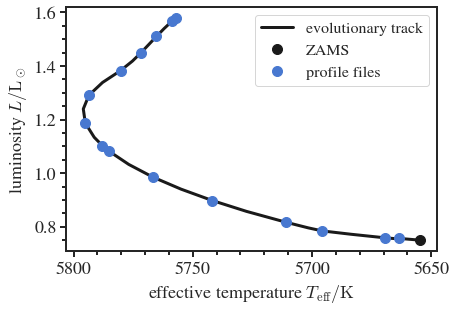

In [6]:
def plot_HR(profile_number=-1):
    plt.plot(10**DF['log_Teff'],           10**DF['log_L'], lw=3, c='k', label='evolutionary track')
    plt.plot(10**DF['log_Teff'].values[0], 10**DF['log_L'].values[0], 'k.', ms=20, label='ZAMS')
    
    first = 1
    for prof_num in index.profile_number:
        hist = get_history(prof_num)
        plt.plot(10**hist['log_Teff'], 10**hist['log_L'], '.',
                 c='r' if prof_num == profile_number else 'b', 
                 label='current model' if prof_num == profile_number else 'profile files' if first else '',
                 #label='profile files' if first and not prof_num == profile_number else '',
                 ms=20)
        if not prof_num == profile_number:
            first = 0
    
    plt.gca().invert_xaxis()
    plt.xlabel(r'effective temperature $T_{\rm{eff}}/\rm{K}$')
    plt.ylabel(r'luminosity $L/\rm{L}_\odot$')
    
    plt.legend()
    #plt.show()

plot_HR()

## Plot stellar structure 

In [7]:
def load_profile(profile_number):
    gong = fgong.load_fgong(os.path.join(logs_dir, 'profile' + str(profile_number) + '.data.FGONG'))
    prof = pd.read_table(   os.path.join(logs_dir, 'profile' + str(profile_number) + '.data'), skiprows=5, sep='\s+')
    return prof, gong

prof, gong = load_profile(5)

In [15]:
prof

,zone,mass,logR,logT,logRho,logP,x_mass_fraction_H,y_mass_fraction_He,z_mass_fraction_metals,brunt_N2,brunt_N,lamb_S
0,1,1.000000e+00,-0.018810,3.759277,-6.762755,4.806097,0.713005,0.269495,0.017499,6.406235e-04,0.025311,0.000017
1,2,1.000000e+00,-0.018811,3.760073,-6.757268,4.812382,0.713005,0.269495,0.017499,6.377421e-04,0.025254,0.000017
2,3,1.000000e+00,-0.018813,3.761233,-6.749606,4.821206,0.713005,0.269495,0.017499,6.231520e-04,0.024963,0.000017
3,4,1.000000e+00,-0.018814,3.763007,-6.738474,4.834115,0.713005,0.269495,0.017499,6.081599e-04,0.024661,0.000017
4,5,1.000000e+00,-0.018818,3.765394,-6.724741,4.850241,0.713005,0.269495,0.017499,5.769493e-04,0.024020,0.000017
...,...,...,...,...,...,...,...,...,...,...,...,...
782,783,1.250073e-06,-2.593619,7.162201,2.026921,17.265548,0.550115,0.430629,0.019256,4.109155e-09,0.000064,0.428334
783,784,6.250366e-07,-2.693970,7.162214,2.026952,17.265585,0.550093,0.430652,0.019256,2.588710e-09,0.000051,0.539680
784,785,3.125184e-07,-2.794318,7.162223,2.026972,17.265609,0.550079,0.430666,0.019256,1.671597e-09,0.000041,0.679965
785,786,1.562592e-07,-2.894665,7.162228,2.026985,17.265623,0.550070,0.430674,0.019256,1.137252e-09,0.000034,0.856711


In [16]:
gong

FGONG(
glob=
[1.98840987e+33 6.66210596e+10 3.43753674e+33 ... 1.74943387e+09
 5.74183448e+03 6.67430000e-08],
var=
[[ 6.66910320e+10  0.00000000e+00  4.83009762e+03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.66908182e+10  0.00000000e+00  4.83013510e+03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.66905782e+10  0.00000000e+00  4.83017810e+03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 8.86660670e+07 -1.56717494e+01  1.45286877e+07 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 7.03740030e+07 -1.63648958e+01  1.45288281e+07 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -7.08396419e+02  1.45290434e+07 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]],
description=
FGONG file
Created by MESAstar

)

In [8]:
strucs = [load_profile(profile_number) for profile_number in index.profile_number]
profs  = [struc[0] for struc in strucs]
gongs  = [struc[1] for struc in strucs]

### Composition profile

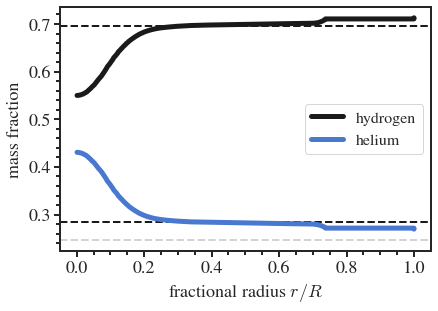

In [19]:
def plot_composition(profile_number):
    gong = gongs[profile_number-1]
    prof = profs[profile_number-1]
    x = 10**prof.logR / np.max(10**prof.logR)
    plt.plot(x, prof.x_mass_fraction_H, lw=5, label='hydrogen', c='k')
    plt.plot(x, prof.y_mass_fraction_He, lw=5, label='helium', c='b')
    plt.axhline(1-0.285-0.0185, c='k', ls='--', zorder=-99)
    plt.axhline(0.285, c='k', ls='--', zorder=-99)
    plt.axhline(0.2463, c='lightgray', ls='--', zorder=-99)
    plt.xlabel(r'fractional radius $r/R$')
    plt.ylabel(r'mass fraction')
    plt.legend()
    #plt.show()

plot_composition(5)

### Propagation diagram

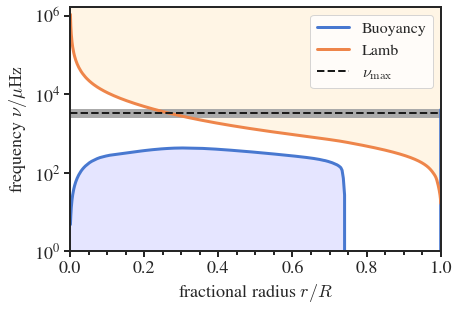

In [10]:
def plot_propagation(profile_number):
    hist = get_history(profile_number)
    gong = gongs[profile_number-1]
    prof = profs[profile_number-1]
    
    x = 10**prof.logR / np.max(10**prof.logR)
    brunt = prof.brunt_N.values/(2*np.pi)*1e6
    lamb  = prof.lamb_S.values*1e6
    plt.plot(x, brunt, lw=3, label='Buoyancy')
    plt.plot(x, lamb, lw=3, label='Lamb')
    
    gmodes = np.minimum(brunt, lamb)
    pmodes = np.maximum(brunt, lamb)
    plt.fill_between(x, 
                     np.zeros(len(gmodes)), 
                     gmodes, 
                     color='blue', alpha=0.1, zorder=-99)
    plt.fill_between(x, 
                     1e99*np.ones(len(pmodes)), 
                     pmodes, 
                     color='orange', alpha=0.1, zorder=-99)
    
    nu_max   = hist.nu_max.values[0]
    Delta_nu = hist.delta_nu.values[0]
    plt.axhline(hist.nu_max.values[0], ls='--', c='k', label=r'$\nu_\max$', zorder=100)
    plt.fill_between([-10, 10], 
                     nu_max-5*Delta_nu, 
                     nu_max+5*Delta_nu, 
                     color='#aaaaaa', zorder=-99)
    
    plt.ylim([1, 500*nu_max])
    plt.xlim([0,1])
    plt.ylabel(r'frequency $\nu/\mu\rm{Hz}$')
    plt.xlabel(r'fractional radius $r/R$')
    plt.legend()
    plt.semilogy()
    #plt.show()

plot_propagation(5)

## Compute frequencies with GYRE

Now let's calculate some frequencies. An example inlist awaits you in the `src/` directory. Copy that over to your `LOGS/` directory and run it with GYRE: 

```
    cp ../src/gyre.in LOGS
    cd LOGS
    $GYRE_DIR/bin/gyre gyre.in
```

In [11]:
def get_frequencies(profile_number, logs_dir=logs_dir):
    return pd.read_table(os.path.join(logs_dir, 'profile' + str(profile_number) + '-freqs.dat'), skiprows=5, sep='\s+')

get_frequencies(1)

,l,n_pg,n_p,n_g,Re(freq),Im(freq),E_norm
0,0,6,6,0,1123.835398,0.0,1.641788e-05
1,0,7,7,0,1293.460360,0.0,7.043062e-06
2,0,8,8,0,1463.733570,0.0,3.170519e-06
3,0,9,9,0,1631.717389,0.0,1.477136e-06
4,0,10,10,0,1798.182375,0.0,6.791934e-07
...,...,...,...,...,...,...,...
184,3,47,47,0,7802.661028,0.0,6.455964e-09
185,3,48,48,0,7961.160323,0.0,6.438214e-09
186,3,49,49,0,8120.401483,0.0,6.548670e-09
187,3,50,50,0,8280.176000,0.0,6.752802e-09


I've prepared a script in the `src/` directory that will allow us to efficiently obtain the frequencies of all our stellar models. Let's run that in a loop: 

```
    for FGONG in *.FGONG; do
        ../../src/gyre6freqs.sh -i $FGONG -f
    done
```

In [12]:
freqs = [get_frequencies(profile_number) for profile_number in index.profile_number]

### Echelle diagram

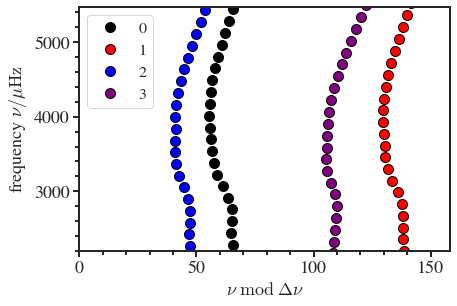

In [13]:
def plot_echelle(profile_number):
    hist = get_history(profile_number)
    gong = gongs[profile_number-1]
    prof = profs[profile_number-1]
    freq = freqs[profile_number-1]
    
    nu_max   = hist.nu_max.values[0]
    Delta_nu = hist.delta_nu.values[0]
    
    freq = freqs[1]
    radial = freq[np.logical_and(np.logical_and(
        freq.l == 0, 
        freq['Re(freq)'] > nu_max-10*Delta_nu), 
        freq['Re(freq)'] < nu_max+10*Delta_nu)]
    Dnu = np.mean(np.diff(radial['Re(freq)'].values))
    
    colors = ('black', 'red', 'blue', 'purple')
    for ell in np.unique(freq.l.values):
        nus = freq[freq.l == ell]
        plt.plot(nus['Re(freq)'] % Dnu,
                 nus['Re(freq)'], '.', 
                 mfc=colors[ell], mec='black', #alpha=0.85,
                 ms=20, mew=1, 
                 label=str(ell))
    
    plt.legend()
    
    plt.xlim([0, Dnu])
    plt.ylim([nu_max-10*Delta_nu, nu_max+10*Delta_nu])
    
    plt.ylabel(r'frequency $\nu/\mu\rm{Hz}$')
    plt.xlabel(r'$\nu\; \rm{mod}\; \Delta\nu$')
    #plt.show()

plot_echelle(1)

## Evolution! 

In [14]:
def plot_panels(profile_number):
    fig = plt.figure(figsize=(12,8))
    
    plt.subplot(2,2,1)
    plot_HR(profile_number)
    
    plt.subplot(2,2,2)
    plot_composition(profile_number)
    
    plt.subplot(2,2,3)
    plot_propagation(profile_number)
    
    plt.subplot(2,2,4)
    plot_echelle(profile_number)
    
    plt.tight_layout()

interact(plot_panels, profile_number=IntSlider(min=1, max=np.max(index.profile_number)));

interactive(children=(IntSlider(value=1, description='profile_number', max=15, min=1), Output()), _dom_classes…

## Eigenfunctions

In [40]:
eig_1 = pd.read_table(logs_dir + 'profile' + profnum + '-freqs/001_-00001', skiprows=5, sep='\s+')
eig_1

,M_r,x,Re(xi_r),Im(xi_r),Re(xi_h),Im(xi_h)
0,0.000000e+00,0.000000,-0.509597,0.0,-0.509597,0.0
1,1.943195e+26,0.000689,-0.509599,0.0,-0.509598,0.0
2,3.886390e+26,0.000868,-0.509600,0.0,-0.509598,0.0
3,7.772778e+26,0.001094,-0.509602,0.0,-0.509599,0.0
4,1.554556e+27,0.001378,-0.509604,0.0,-0.509600,0.0
...,...,...,...,...,...,...
4506,9.942049e+33,1.001596,1.348792,0.0,0.664295,0.0
4507,9.942049e+33,1.001597,1.348797,0.0,0.664292,0.0
4508,9.942049e+33,1.001599,1.348802,0.0,0.664289,0.0
4509,9.942049e+33,1.001600,1.348807,0.0,0.664286,0.0


In [41]:
eigs = {}
for fname in os.listdir(logs_dir + 'profile' + profnum + '-freqs'):
    if fname[:4] != '001_':
        continue
    eig_i = pd.read_table(logs_dir + 'profile' + profnum + '-freqs/' + fname, sep='\s+', skiprows=5)
    eig_i = eig_i.iloc[np.unique(eig_i.x, return_index=True)[1]]
    eigs[int(fname.split('_')[1])] = eig_i

In [42]:
eigs[-1].x

0       0.000000
1       0.000689
2       0.000868
3       0.001094
4       0.001378
          ...   
4506    1.001596
4507    1.001597
4508    1.001599
4509    1.001600
4510    1.001601
Name: x, Length: 4510, dtype: float64

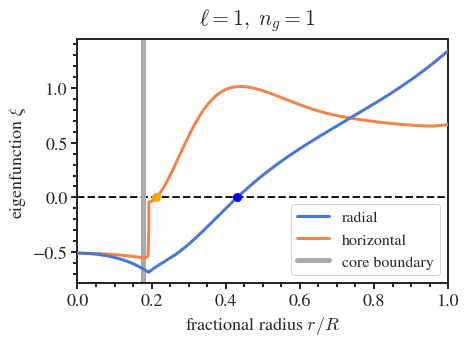

In [43]:
eig = eigs[-1] #eig_1
plt.plot(eig.x, eig['Re(xi_r)'], label='radial', lw=3, zorder=11)
plt.plot(eig.x, eig['Re(xi_h)'], label='horizontal', lw=3, zorder=10)
plt.xlim([0,1])
[plt.plot(r, 0, 'o', mew=3, zorder=100, c='blue') 
 for r in interpolate.InterpolatedUnivariateSpline(eig.x, eig['Re(xi_r)']).roots()]
[plt.plot(r, 0, 'o', mew=3, zorder=100, c='orange') 
 for r in interpolate.InterpolatedUnivariateSpline(eig.x, eig['Re(xi_h)']).roots()]
plt.xlabel(r'fractional radius $r/R$')
plt.ylabel(r'eigenfunction $\xi$')
plt.axhline(0, ls='--', c='k', alpha=1, zorder=-10)
plt.axvline(find_pi(0), ls='-', lw=5, c='darkgray', label='core boundary', zorder=-10)
#plt.grid()
plt.suptitle(r'$\ell = 1,\; n_g = 1$')
plt.legend()
plt.show()

### Eigenfunctions with slider 

In [44]:
def plot_eigs(n_g):
    eig = eigs[-n_g] 
    plt.plot(eig.x, eig['Re(xi_r)'], label='radial', lw=3, zorder=11)
    plt.plot(eig.x, eig['Re(xi_h)'], label='horizontal', lw=3, zorder=10)
    plt.xlim([0,1])
    [plt.plot(r, 0, 'o', mew=3, zorder=100, c='blue') 
     for r in interpolate.InterpolatedUnivariateSpline(eig.x, eig['Re(xi_r)']).roots()]
    [plt.plot(r, 0, 'o', mew=3, zorder=100, c='orange') 
     for r in interpolate.InterpolatedUnivariateSpline(eig.x, eig['Re(xi_h)']).roots()]
    plt.xlabel(r'fractional radius $r/R$')
    plt.ylabel(r'eigenfunction $\xi$')
    plt.axhline(0, ls='--', c='k', alpha=1, zorder=-10)
    plt.axvline(find_pi(0), ls='-', lw=5, c='darkgray', label='core boundary', zorder=-10)
    #plt.grid()
    plt.suptitle(r'$\ell = 1,\; n_g = ' + str(n_g) + r'$')
    plt.legend()
    plt.show()

interact(plot_eigs, n_g=IntSlider(min=1, max=16, step=1, value=2, 
                       continuous_update=True));

interactive(children=(IntSlider(value=2, description='n_g', max=16, min=1), Output()), _dom_classes=('widget-i…

In [111]:
# plot in terms of Pi_0 / Pi_r 

### Phase diagrams

In [49]:
def plot_phase(n_g):
    eig = eigs[-n_g] 
    plt.plot(eig['Re(xi_r)'], eig['Re(xi_h)'], lw=3, zorder=11)
    plt.xlabel(r'radial displacement $\xi_r$')
    plt.ylabel(r'horizontal displacement $\xi_h$')
    plt.axhline(0, ls='--', c='k', alpha=1, zorder=-10)
    plt.axvline(0, ls='--', c='k', alpha=1, zorder=-10)
    plt.xlim([-5, 5])
    plt.ylim([-50, 50])
    plt.suptitle(r'$\ell = 1,\; n_g = ' + str(n_g) + r'$')
    plt.show()

interact(plot_phase, n_g=IntSlider(min=1, max=50, step=1, value=35, 
                       continuous_update=True));

interactive(children=(IntSlider(value=20, description='n_g', max=50, min=1), Output()), _dom_classes=('widget-…

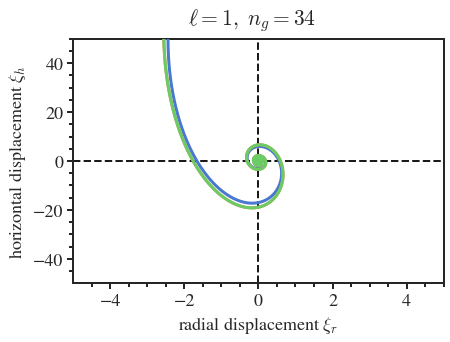

In [50]:
for n_g in [33, 34, 34]:
    eig = eigs[-n_g] 
    plt.plot(eig['Re(xi_r)'], eig['Re(xi_h)'], lw=3, zorder=11)

plt.xlabel(r'radial displacement $\xi_r$')
plt.ylabel(r'horizontal displacement $\xi_h$')
plt.axhline(0, ls='--', c='k', alpha=1, zorder=-10)
plt.axvline(0, ls='--', c='k', alpha=1, zorder=-10)
plt.xlim([-5, 5])
plt.ylim([-50, 50])
plt.show()

### Mode trappings

In [51]:
eig.M_r

0        0.000000e+00
1        9.715994e+25
2        1.943197e+26
3        3.886391e+26
4        7.772780e+26
             ...     
10323    9.942049e+33
10324    9.942049e+33
10325    9.942049e+33
10326    9.942049e+33
10327    9.942049e+33
Name: M_r, Length: 10283, dtype: float64

In [52]:
eig = eigs[-10]
angle_x = integrate.trapezoid(eig['Re(xi_r)']**2 * eig.x, eig.M_r) / \
          integrate.trapezoid(eig['Re(xi_r)']**2,         eig.M_r)
angle_x

0.40670113382827544

In [53]:
n_gs = []
angle_xs = []

for mode in dipole_g.iterrows():
    n_g = mode[1]['n_g']
    eig = eigs[-n_g]
    angle_x = integrate.trapezoid(eig['Re(xi_r)']**2 * eig.x, eig.M_r) / \
              integrate.trapezoid(eig['Re(xi_r)']**2,         eig.M_r)
    dipole_g.loc[mode[0], 'trap'] = angle_x
    #n_gs += [n_g]
    #angle_xs += [angle_x]


### Propagation diagram with $\mu$ and $\xi$

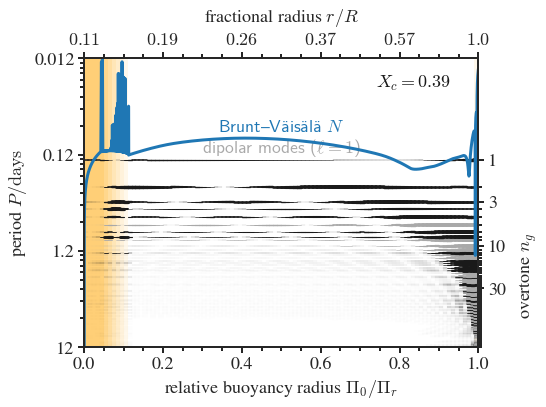

In [56]:
buoy_rad = N[N2>0]/(10**-6 * 2*np.pi)
find_pi = lambda x: prof.x[N2>0][np.where(Pi_0/Pi_r > x)[0][0]]

plt.figure(figsize=(8,6))

plt.plot(Pi_0 / Pi_r, buoy_rad, 
         zorder=10, lw=3, label=r'Brunt–Väisälä',
        c='tab:blue')
plt.xlabel(r'relative buoyancy radius $\Pi_0/\Pi_r$')
#plt.ylabel(r'frequency $\nu/\mu\rm{Hz}$')
plt.ylabel(r'period $P/\rm{days}$')
plt.xlim([0,1])
ylim = [1, 10**3]
plt.ylim(ylim)
plt.semilogy()

ax = plt.gca()

yticks = [10**0, 10**1, 10**2, 10**3]
nutoP = lambda x: 1/(x * 10**-6) / s_per_day
ax.set_yticks(yticks)
ax.set_yticklabels(['%2.2g' % nutoP(x) for x in yticks])

plt.text(0.5, buoy_rad[np.where(Pi_0 / Pi_r >= 0.5)[0][0]]*1.2, r'Brunt–Väisälä $N$', ha='center',
        c='tab:blue', family='Latin Modern Sans')
#plt.legend()

plt.text(0.93, ylim[1]*0.5, r'$X_c = %.2f$' % model.x_mass_fraction_H.values[-1], 
         ha='right', c='k', family='Latin Modern Sans')

# plot mu
# mu ~= 4 / (6*X + Y + 2)
norm = mpl.colors.Normalize(vmin=0.62, vmax=4/3)
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["white","orange","red"])
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
x = 10**model.logR / np.max(10**model.logR)
xs = np.linspace(0, 1, 101)
for ii in range(len(xs)-1):
    x_i = (xs[ii]+xs[ii+1])/2
    col = cmap.to_rgba( model.mu[ np.argmin(np.abs(x - find_pi(x_i))) ] )
    plt.axvspan(xs[ii], xs[ii+1], zorder=-100, fc=col, ec=col)

# plot eigenfunctions 
for mode in dipole_g.iterrows():
    #plt.axhline(mode[1]['Re(freq)'], ls='--', c='k', alpha=0.35)
    eig = eigs[-mode[1]['n_g']]
    #xir = np.abs(eig['Re(xi_r)']) / np.max(np.abs(eig['Re(xi_r)'])) * 4 #/ np.log10(10+mode[1]['n_g'])
    #for ii in range(len(xs)-1):
    #    x_i = (xs[ii]+xs[ii+1])/2
    #    plt.plot([xs[ii], xs[ii+1]], [mode[1]['Re(freq)']]*2, 
    #             ls='-', c='darkgray', alpha=1, ms=0,
    #             lw=xir[ np.argmin(np.abs(eig.x - find_pi(x_i))) ] )
    xih = np.abs(eig['Re(xi_h)']) / np.max(np.abs(eig['Re(xi_h)'])) * 4 #/ np.log10(10+mode[1]['n_g'])
    for ii in range(len(xs)-1):
        x_i = (xs[ii]+xs[ii+1])/2
        plt.plot([xs[ii], xs[ii+1]], [mode[1]['Re(freq)']]*2, ls='-', 
                 c='darkgray' if mode[1].trap>cutoff else 'k',
                 alpha=1, ms=0,
                 lw=xih[ np.argmin(np.abs(eig.x - find_pi(x_i))) ] )
    if mode[1]['n_g'] == 1:
        plt.text(0.5, mode[1]['Re(freq)']*1.2, r'dipolar modes ($\ell = 1$)', ha='center',
            c='darkgray', family='Latin Modern Sans')

top = ax.twiny()
top.set_xlim(ax.get_xlim())
top.set_xlabel(r'fractional radius $r/R$', labelpad=10)

xs = [0, 0.2, 0.4, 0.6, 0.8, 0.99999]
top.set_xticks(xs)
top.set_xticklabels([r'$%0.2f$' % find_pi(x) if x<0.999 else r'$1.0$' for x in xs])

## plot overtones on the right y-axis 
right = ax.twinx()
right.set_ylim(ax.get_ylim())
right.semilogy()
right.set_ylabel(r'overtone $n_g$')
right.yaxis.set_label_coords(1.1,0.25)

#per_spac = dipole_g[~np.isnan(dipole_g.dP)]
#per_spac = per_spac[per_spac.P < 5]
#right.set_yticks(per_spac['Re(freq)'].values[::-1][[0,1,3,7,15,31]])
#right.set_yticklabels([r'$%s$' % x for x in per_spac.n_g.values[::-1][[0,1,3,7,15,31]]])
right.set_yticks([dipole_g['Re(freq)'].values[dipole_g.n_g == x][0] for x in [1, 3, 10, 30]])
right.set_yticklabels([1, 3, 10, 30])
right.set_yticks([x for x in dipole_g['Re(freq)'].values if x > ylim[0]], minor=True)
right.set_yticklabels([], minor=True)

plt.tight_layout()
#plt.savefig('propagation.pdf')

plt.show()